# Section on making discretized spike stuff
## probably will want to move this functionality into a dedicated utility once finished

In [2]:
# required libraries with sample of how method should work
import numpy as np

# Example vectors
a = np.array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b = np.array([-1, 0.75, 2.5, 4.5, 6.5, 8.5, 20])
b_good = b[(b >= a[0]) & (b <= a[-1])]
print((b >= a[0]) & (b <= a[-1]))

# Initialize the binary vector
binary_vector = np.zeros(len(a), dtype=int)

# Find the nearest element in 'a' that is less than the elements in 'b'
for event_time in b_good:
    # Find indices where 'a' is less than 'event_time'
    valid_indices = np.where(a < event_time)[0]
    if valid_indices.size > 0:
        nearest_index = valid_indices[-1]  # Taking the last valid index
        binary_vector[nearest_index]+= 1

print(binary_vector)

[False False  True  True  True  True False]
[0 1 0 1 0 1 0 1 0 0]


In [1]:
# Core components of method for making binary spikes
# compatible with the input/output structure of PGAS
import numpy as np

# method for converting spike times to a binary vector as required by Giovanni's implementation of the PGAS algorithm
def spike_times_2_binary(spike_times,time_stamps):
    # initialize the binary vector
    binary_vector = np.zeros(len(time_stamps), dtype=int)

    # get event times within the time_stamps ends
    good_spike_times = spike_times[(spike_times >= time_stamps[0]) & (spike_times <= time_stamps[-1])]
    
    # Find the nearest element in 'a' that is less than the elements in 'b'
    for event_time in good_spike_times:
        # Find indices where 'a' is less than 'event_time'
        valid_indices = np.where(time_stamps < event_time)[0]
        if valid_indices.size > 0:
            nearest_index = valid_indices[-1]  # Taking the last valid index
            binary_vector[nearest_index] += 1

    return binary_vector

# For opening the janelia datasets
def open_Janelia_1(j_path):
    all_data = sio.loadmat(j_path)
    dff = all_data['dff']
    time_stamps = all_data['time_stamps']
    spike_times = all_data['ap_times'] 

    return time_stamps, dff, spike_times

def unroll_dat_files(dat_file):
    '''
    PGAS contain the following output variables:
    -B = basline drift, brownian
    -S = discretized spike number per time bin
    -C = "calcium" value - really more akin to a DFF-like metric
    -Y = original data (not included in PGBAR output)
    '''
    

    data = np.genfromtxt(dat_file, delimiter=',', skip_header=1)
    #Dealing out data
    index = data[:,0]
    B = data[:,2]
    S = data[:,3]
    C = data[:,4]
    
    #Note that files produced by PGBAR (rather than the more general PGAS) lack Y - for now not including it
    try:
        Y = data[:,5]
    except:
        Y = np.nan
    
    return index,B,S,C,Y

# Checking to make sure that I'm getting reasonable outputs from the PGAS algorithm with known spikes

(1100.0, 1900.0)

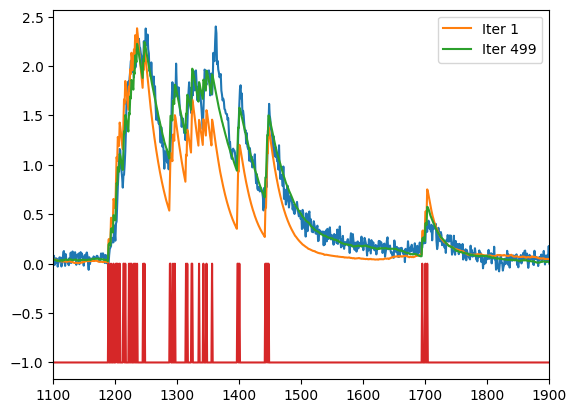

In [5]:
# Open the file
file = r'/scratch/gpfs/gerardjb/TEST2/sample_data/output/traj_samples_default_janelia_sample_excitatory.dat'
data = np.genfromtxt(file, delimiter=',', skip_header=1)

#Dealing out data
index = data[:,0]
B = data[:,2]
S = data[:,3]
C = data[:,4]
Y = data[:,5]

#Define trajectory run numbers and plot
start_epoch = 20
end_epoch = 25
plt.figure()
plt.plot(Y[index==0])
for epoch in np.array([1,499]):
    plt.plot(B[index == epoch]+C[index==epoch],label=f'Iter {epoch}')

plt.plot(S[index==0]-1)
plt.legend()
ax = plt.gca()
ax.set_xlim([1100,1900])

(83.0, 84.0)

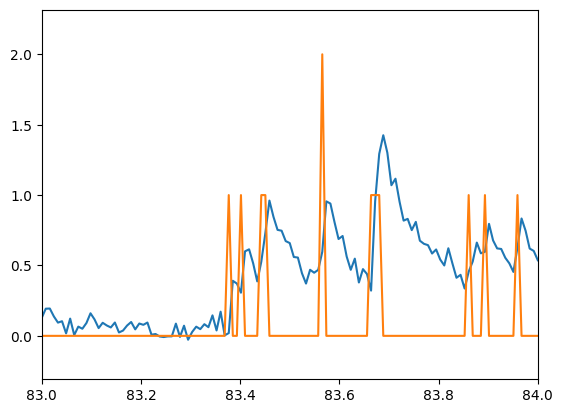

In [ ]:
import matplotlib.pyplot as plt
import os
import scipy.io as sio

#Open the test file and make some plots
janelia_file = "jGCaMP8f_ANM478407_cell01"
filename = os.path.join("gt_data",janelia_file+".mat")
time_stamps, dff, spike_times = open_Janelia_1(filename)

#Get binary vector
binary_vector = spike_times_2_binary(spike_times,time_stamps[0,:])

# Plot
plt.figure()
plt.plot(time_stamps[0,:],dff[0,:])
plt.plot(time_stamps[0,:],binary_vector)
ax = plt.gca()
ax.set_xlim([83,84])

# Looking at the parameter distributions that come out of each sample cell, then plots of generated data

[5.37672310e-05 5.45392090e+02 1.10299758e-05 2.20217490e+00
 3.71863110e-02 9.12515530e-03 1.32519198e+00]


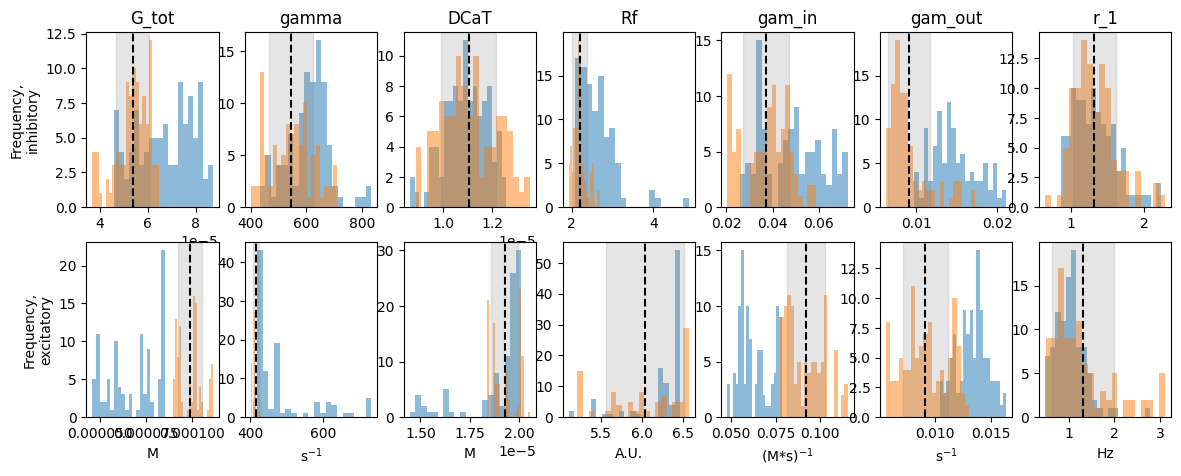

<function print>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 

param_sample_file = r"sample_data/output/param_samples_default_janelia_sample_inhib.dat"
param_sample_file2 = r"sample_data/output/param_samples_default_janelia_sample_excitatory.dat"
#param_sample_file3 = r"sample_data/output/param_samples_default_janelia_sample_excitatory3_1.dat"
param_samples = np.loadtxt(param_sample_file,skiprows=1,delimiter=",")
param_samples2 = np.loadtxt(param_sample_file2,skiprows=1,delimiter=",")
#param_samples3 = np.loadtxt(param_sample_file3,skiprows=1,delimiter=",")
param_names = ['G_tot','gamma','DCaT','Rf','gam_in','gam_out','r_1']
data_labels = ['M','s$^{-1}$','M','A.U.','(M*s)$^{-1}$','s$^{-1}$','Hz']
burnin = 100

good_params = param_samples[:,np.concatenate((np.arange(6),[8]))]
good_params2 = param_samples2[:,np.concatenate((np.arange(6),[8]))]
#good_params3 = param_samples3[:,0:6]

Cparams_inh = np.mean(good_params[burnin:,:],axis=0)
print(Cparams_inh)
Cparams_exc = np.mean(good_params2[burnin:,:],axis=0)
#Cparams_exc3_1 = np.mean(good_params3[burnin:,:],axis=0)

#histograms of each
n_columns = good_params.shape[1]
fig,axes = plt.subplots(2,n_columns,figsize=(14,5))
for col_idx in range(n_columns):
  # Get the current column data
  shortest_col = np.min([len(good_params[:,col_idx]),len(good_params2[:,col_idx])])
  column_data = np.array([good_params[0:shortest_col, col_idx],good_params2[0:shortest_col,col_idx]]).T#,good_params3[:,col_idx]]).T

  for row in range(2):
    
    # Plot the histogram as a stacked bar
    axes[row,col_idx].hist(column_data[0:burnin,row], bins=20, stacked=True,alpha=0.5)
    axes[row,col_idx].hist(column_data[burnin+1:,row], bins=20, stacked=True,alpha=0.5)
    axes[row,col_idx].axvline(np.mean(column_data[burnin+1:,row]),color='black',linestyle='dashed')

    # Define the rectangle properties (adjust alpha for transparency)
    rect = Rectangle(xy=(np.mean(column_data[burnin+1:,row]) - np.std(column_data[burnin+1:,row]), 0),\
      width=2 * np.std(column_data[burnin+1:,row]), height=max(axes[row,col_idx].get_ylim()),\
      alpha=0.2, color='gray')  # Light blue shade

    # Add the rectangle to the current subplot
    axes[row,col_idx].add_patch(rect)
    if col_idx==0:
      if row==0:
        axes[row,col_idx].set_ylabel(f"Frequency,\ninhibitory")
      if row==1:
        axes[row,col_idx].set_ylabel(f"Frequency,\nexcitatory")
      #if row==2:
        #axes[row,col_idx].set_ylabel(f"Frequency,\nexcitatory2")

    #if row==1:
      #axes[row,col_idx].set_xlim(axes[0,col_idx].get_xlim())

  # Set labels and title for each subplot (optional)
  axes[1,col_idx].set_xlabel(data_labels[col_idx])
  
  axes[0,col_idx].set_title(param_names[col_idx])

# Show the plot
plt.show()
print

52
G_tot = 5.37672e-05; gam_out = 0.00912516
G1 = 5.13909e-07; G6 = 0.955939
kon_N = 0.94944; koffPN2 = 386.105
N spike = 1; total Ca = 0.1103
N spike = 34; total Ca = 3.75019


<Figure size 640x480 with 0 Axes>

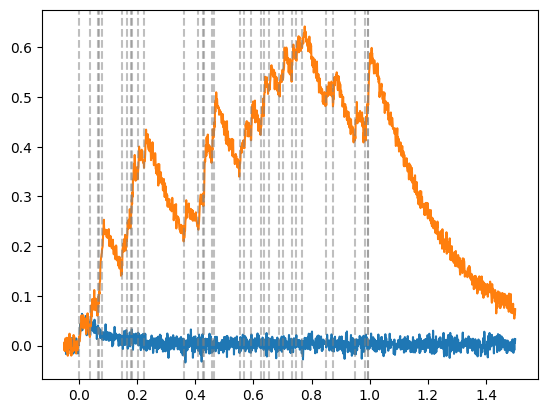

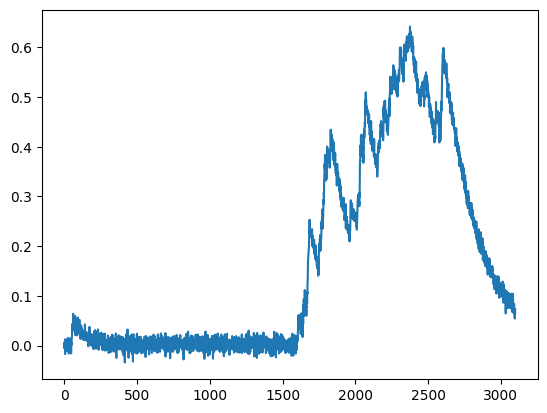

In [2]:
# Now some simulations to see how those look
import numpy as np
import matplotlib.pyplot as plt
import build.pgas_bound as pgas
np.random.seed(123)

# Sim setup
#Gcamp
Gparam_file="src/spike_find/pgas/20230525_gold.dat"
Gparams = np.loadtxt(Gparam_file)
gcamps = [pgas.GCaMP(Gparams,Cparams_inh)]#[pgas.GCaMP(Gparams,Cparams_exc)]#,
#Time/stims
sampling_rate = 1000
sim_start = -.05
sim_end = 1.5
sim_time = np.linspace(sim_start,sim_end,num=np.int(np.round((sim_end-sim_start)*sampling_rate)))
#Poisson stims
poisson_rate = 30
event_counts = np.random.poisson(poisson_rate / sampling_rate, len(sim_time))
event_trace = np.where(event_counts > 0, 1, 0)
print(np.sum(event_trace))
poisson_stim = sim_time[np.where(event_trace)]
poisson_stim = np.concatenate(([0],poisson_stim[(poisson_stim>0) & (poisson_stim<1)]))
single_stim = np.array([0])
stims = [single_stim,poisson_stim]
#Noise
noise_lev = 0.01
plt.figure(num=1)
dff = np.array([])
for gcamp in gcamps:
    plt.figure()
    for stim in stims:
        gcamp.integrateOverTime(sim_time.astype(float),stim.astype(float))
        sim = gcamp.getDFFValues()
        noise = np.random.normal(0,noise_lev, size=sim.shape)
        dff = np.concatenate((dff,sim+noise))
        plt.plot(sim_time,sim+noise)
        if len(stim)>1:
            for event in stim:
                plt.axvline(event,ls='--',color='gray',alpha=0.5)
ax = plt.gca()
#ax.set_xlim([-.01,0.2])

plt.figure()
plt.plot(dff)


(3100,)
1.55


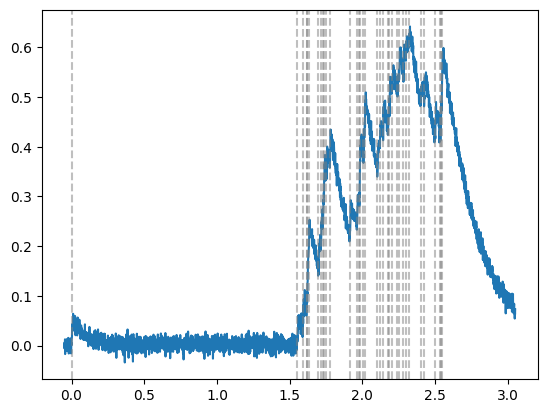

In [4]:
import scipy.io as sio
import os

print(dff.shape)
print(sim_end-sim_start)
time = np.concatenate((sim_time,sim_time+sim_end-sim_start+1/sampling_rate))
plt.figure()
plt.plot(time,dff[0:len(time)])
all_stim = np.concatenate((single_stim,poisson_stim+sim_end-sim_start+1/sampling_rate))
for stim in all_stim:
    plt.axvline(stim,ls='--',color='gray',alpha=0.5)

ax = plt.gca()
#ax.set_xlim([1.5,1.7])
test_path = os.path.join('sample_data','output','sim4fig3')
os.makedirs(test_path,exist_ok=True)

sio.savemat(os.path.join(test_path,'test_inh.mat'),{'dff':dff[0:len(time)],'time_stamps':time,'ap_times':np.concatenate((single_stim,poisson_stim+sim_end-sim_start+1/sampling_rate))})
data = np.column_stack((time,dff[0:len(time)]))
pgbar_f_out = 'sim_data_inhibitory.dat'
np.savetxt(pgbar_f_out, data, fmt='%e')

# Final preparation for running PGAS against the simualtions
## Here I am routing the simulations derived from realistic cell parameters for inhibitory and excitatory cells through the pgas algorithm for inference. As a first pass, I used the actual spikes train as part of the input. Next, I will try full inference over states including unknown spikes

/tmp/ipykernel_110583/2628373718.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  start_pt = np.array([axes[0].get_xlim()[1]-perc_l,axes[0].get_ylim()[1]])
/tmp/ipykernel_110583/2628373718.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  start_pt = np.array([axes[0].get_xlim()[1]-perc_l,axes[0].get_ylim()[1]])


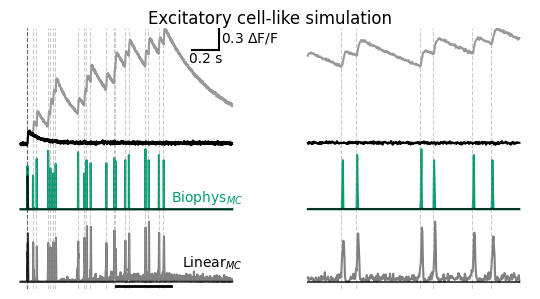

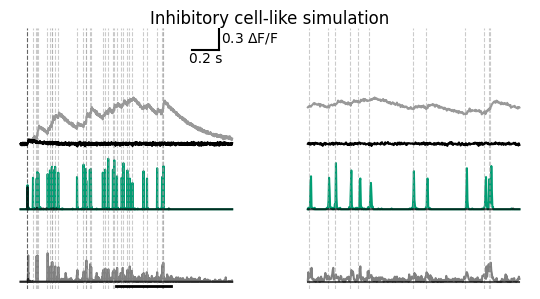

In [27]:
import scipy.io as sio
import os
import numpy as np
import matplotlib.pyplot as plt

#%matplotlib notebook

def open_Janelia_1(j_path):
    all_data = sio.loadmat(j_path)
    dff = all_data['dff']
    time_stamps = all_data['time_stamps']
    spike_times = all_data['ap_times'] 

    return time_stamps, dff, spike_times

def spike_times_2_binary(spike_times,time_stamps):
    # initialize the binary vector
    binary_vector = np.zeros(len(time_stamps), dtype=int)

    # get event times within the time_stamps ends
    good_spike_times = spike_times[(spike_times >= time_stamps[0]) & (spike_times <= time_stamps[-1])]
    
    # Find the nearest element in 'a' that is less than the elements in 'b'
    for event_time in good_spike_times:
        # Find indices where 'a' is less than 'event_time'
        valid_indices = np.where(time_stamps < event_time)[0]
        if valid_indices.size > 0:
            nearest_index = valid_indices[-1]  # Taking the last valid index
            binary_vector[nearest_index] += 1

    return binary_vector


#Getting the file information
filep1 = "/scratch/gpfs/gerardjb/TEST2/sample_data/output"
p2 = "sim4fig3"
data_stub = [ "test_exc.mat","test_inh.mat"]
sim_stub = ["traj_samples_default_janelia_sample_excitatory.dat","traj_samples_default_janelia_sample_inhibitory2.dat"]
pgbar_stub = ["traj_samples_experiment4_exc_AR2.dat","traj_samples_inhibitory_AR2.dat"]



#Load and process the inferences
recalc = False
if recalc:
    #initialize lists
    times = [];dffs = [];binary_spikes_list = [];spike_times_list=[];
    trajs = [];spks = []
    trajs_ar = [];spks_ar = [];
    avg_trajs = [];std_trajs = [];avg_spks = []
    avg_trajs_ar = [];std_trajs_ar = [];avg_spks_ar = []

    for i in np.arange(len(data_stub)):
        #Get data
        data_file = os.path.join(filep1,p2,data_stub[i])
        time,data_dff,spike_times = open_Janelia_1(data_file)
        times.append(time[0,:])
        dffs.append(data_dff[0,:])
        spike_times_list.append(spike_times)
        binary_spikes_list.append(spike_times_2_binary(spike_times,times[i]))
    
        #Getting the PGAS and PGBAR output
        pgas_file = os.path.join(filep1,sim_stub[i])
        index, B, S, C, Y = unroll_dat_files(pgas_file)
        pgbar_file = os.path.join(filep1,p2,pgbar_stub[i])
        index_ar, B_ar, S_ar, C_ar, Y_ar = unroll_dat_files(pgbar_file)
        
        #Now reshaping for mean trajectories
        trajs.append(B.reshape((-1,np.sum(index==0))).T + C.reshape((-1,np.sum(index==0))).T)
        avg_trajs.append(np.mean(trajs[i][:,-100:-1],axis=1))
        std_trajs.append(np.std(trajs[i][:,-100:-1],axis=1))
        spks.append(S.reshape((-1,np.sum(index==0))).T)
        avg_spks.append(np.mean(spks[i][:,-100:-1],axis=1))
        #AR ones
        trajs_ar.append(B_ar.reshape((-1,np.sum(index_ar==0))).T + C_ar.reshape((-1,np.sum(index_ar==0))).T)
        avg_trajs_ar.append(np.mean(trajs_ar[i][:,-100:-1],axis=1))
        std_trajs_ar.append(np.std(trajs_ar[i][:,-100:-1],axis=1))
        spks_ar.append(S_ar.reshape((-1,np.sum(index_ar==0))).T)
        avg_spks_ar.append(np.mean(spks_ar[i][:,-100:-1],axis=1))

#Plots
#For saving
save_names = ['main_fig3_panelsI-J.pdf','main_fig3_panelsK-L.pdf']

#Stuff for labels
x_len = 0.2# in s
y_len = 0.3# in DF/F
sel_win = [slice(0,1550),slice(700,1100)]
plt.rcParams['font.family'] = 'DejaVu Sans'

dat_cols = [(0,0,0),(0.6,0.6,0.6)];spk_cols = [(0,0,0,0.7),'#009E73'];spk_ar_cols = [(0,0,0,0.7),(0.5,0.5,0.5)];
titles = ["Excitatory cell-like simulation","Inhibitory cell-like simulation"]

#Init and make
for i in np.arange(len(data_stub)):
    fig, axes = plt.subplots(1,len(data_stub), figsize=(5.5, 3))
    data_re = dffs[i].reshape((2,1550)).T
    avg_spks_re = avg_spks[i].reshape((2,1550)).T
    avg_spks_ar_re = avg_spks_ar[i].reshape((2,1550)).T
    for win in np.arange(len(sel_win)):
        #Select out only spikes on plotted interval
        good_spks = (spike_times_list[i][0]-times[i][1551]-0.05>times[i][sel_win[win].start]) &\
            (spike_times_list[i][0]-times[i][1551]-0.05<times[i][sel_win[win].stop])
        
        for col_idx in np.flipud(range(2)):
            axes[win].plot(times[i][sel_win[win]],data_re[sel_win[win],col_idx],color=dat_cols[col_idx])
            axes[win].plot(times[i][sel_win[win]],avg_spks_re[sel_win[win],col_idx]-0.9,color=spk_cols[col_idx])
            axes[win].plot(times[i][sel_win[win]],avg_spks_ar_re[sel_win[win],col_idx]-1.9,color=spk_ar_cols[col_idx])
        
            if col_idx==0 and win!=1:
                axes[win].axvline(0,ls='--',color=dat_cols[col_idx],alpha=0.5,linewidth=0.8)
            elif col_idx==1:
                for spike in spike_times_list[i][0][good_spks]-times[i][1551]-0.05:
                    axes[win].axvline(spike,ls='--',color=dat_cols[col_idx],alpha=0.5,linewidth=0.8)
    
        if i==0 and win==0:
            axes[win].text(axes[win].get_xlim()[-1],-0.8,'Biophys$_{MC}$',ha='right',color=spk_cols[1])
            axes[win].text(axes[win].get_xlim()[-1],-1.7,'Linear$_{MC}$',ha='right',color=dat_cols[0])
    
        #Labels and axes stuff
        #axes[win].set_title(titles[i])
        axes[win].set_ylim([-2,1.6])
        axes[win].set_xticks([])
        axes[win].set_yticks([])
        for spine in axes[win].spines.values():
            spine.set_visible(False)


    #Now do scale bars in the first panel
    #Start from the upper corner
    perc_l = 0.1*np.diff(axes[0].get_xlim())
    start_pt = np.array([axes[0].get_xlim()[1]-perc_l,axes[0].get_ylim()[1]])
    axes[0].plot((start_pt[0]-x_len,start_pt[0]),(start_pt[1]-y_len,start_pt[1]-y_len),color='k')
    axes[0].plot((start_pt[0],start_pt[0]),(start_pt[1]-y_len,start_pt[1]),color='k')
    axes[0].text(start_pt[0]-x_len/2,start_pt[1]-y_len-0.03,f"{x_len} s",ha='center',va='top')
    axes[0].text(start_pt[0]+0.01,start_pt[1]-y_len/2,f"{y_len} $\Delta$F/F",ha='left',va='center')
    axes[0].plot((times[0][sel_win[win].start],times[0][sel_win[win].stop]),(axes[0].get_ylim()[0]+0.04,axes[0].get_ylim()[0]+0.04),color='k',linewidth=2)
    
    plt.tight_layout()
    fig.suptitle(titles[i], fontsize=12)
    plt.subplots_adjust(top=0.92)
    plt.savefig(save_names[i],format='pdf',dpi=300)



# A cell just to look at new outputs from pgas

In [6]:
import scipy.io as sio
import os
import numpy as np
import matplotlib.pyplot as plt

pgas_out = r'/scratch/gpfs/gerardjb/TEST2/sample_data/output/traj_samples_default_janelia_seed1.dat'
#data = np.genfromtxt(pgas_out, delimiter=',', skip_header=1)
#Dealing out data
#index = data[:,0]
#B = data[:,2]
#S = data[:,3]
#C = data[:,4]
#Y = data[:,5]
index, B, S, C, Y = unroll_dat_files(pgas_out)

test_range = np.array([99,100,101,102])

plt.subplot(2,2,1)
for ind in test_range:
    plt.plot(B[index==ind,])
    plt.ylabel("baseline state")

plt.subplot(2,2,2)
for ind in test_range:
    plt.plot(B[index==ind,])
    ax = plt.gca()
    ax.set_xlim([0,150])

plt.subplot(2,2,3)
plt.plot(Y[index==0],color='k')
for ind in test_range:
    plt.plot(B[index==ind,]+C[index==ind],label=ind)
    plt.ylabel("DFF")
    plt.xlabel("time bin")

plt.subplot(2,2,4)
plt.plot(Y[index==0],color='k')
for ind in test_range:
    plt.plot(B[index==ind,]+C[index==ind],label=ind)
    plt.xlabel("time bin")
    ax = plt.gca()
    ax.set_xlim([0,150])

ax = plt.gca()
#ax.set_xlim([0,400])

NameError: name 'unroll_dat_files' is not defined

[0 1 2 3 4 5 8]
[0 1]


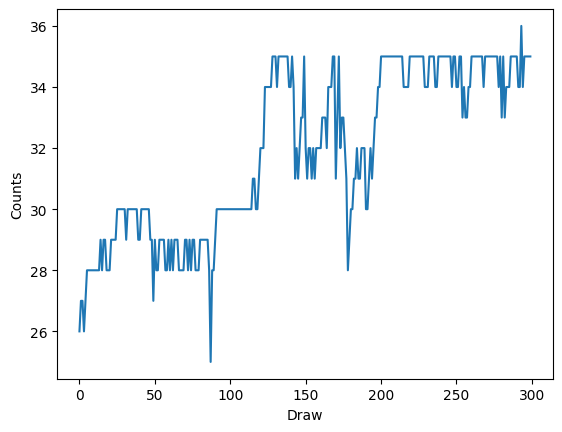

In [31]:
# Now looking at the spike counts per draw
uni_inds = np.unique(index)
counts = np.zeros(uni_inds.shape)
for ind in uni_inds:
    counts[np.int(ind)] = np.sum(S[index==np.int(ind)])

plt.plot(counts)
plt.xlabel('Draw')
plt.ylabel('Counts')

print(np.concatenate((np.arange(6),[8])))
print(np.arange(len(data_stub)))

# Misc stuff

In [12]:
# Futzing aroud a bit with font managers
from matplotlib.font_manager import FontManager
fm = FontManager()
font_names = sorted(set(f.name for f in fm.ttflist))
for font in font_names:
    print(font)

C059
D050000L
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Droid Sans
Droid Sans Arabic
Droid Sans Armenian
Droid Sans Devanagari
Droid Sans Ethiopic
Droid Sans Fallback
Droid Sans Georgian
Droid Sans Hebrew
Droid Sans Japanese
Droid Sans Tamil
Droid Sans Thai
Liberation Mono
Nimbus Mono PS
Nimbus Roman
Nimbus Sans
Nimbus Sans Narrow
P052
STIXGeneral
STIXNonUnicode
STIXSizeFiveSym
STIXSizeFourSym
STIXSizeOneSym
STIXSizeThreeSym
STIXSizeTwoSym
URW Bookman
URW Gothic
Z003
cmb10
cmex10
cmmi10
cmr10
cmss10
cmsy10
cmtt10
